<a href="https://colab.research.google.com/github/taylan-sen/CIS490a_intro_ai/blob/main/Topic_models_with_Gensim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic models with Gensim

Gensim is a popular library for topic modeling. Here we'll see how it stacks up to scikit-learn.

In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data

--2023-10-25 14:03:34--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6483086 (6.2M) [text/csv]
Saving to: ‘data/recipes.csv’

recipes.csv         100%[===================>]   6.18M  26.9MB/s    in 0.2s    

2023-10-25 14:03:35 (26.9 MB/s) - ‘data/recipes.csv’ saved [6483086/6483086]

--2023-10-25 14:03:35--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10501219 (10M) [text/csv]
Saving to: ‘data/state-of-the-union

## Gensim vs. Scikit-learn

[Gensim](https://radimrehurek.com/gensim/) is a very very popular piece of software to do topic modeling with (as is [Mallet](http://mallet.cs.umass.edu/topics.php), if you're making a list). Since we're using scikit-learn for everything else, though, we use scikit-learn instead of Gensim when we get to topic modeling.

Since someone might show up one day offering us tens of thousands of dollars to demonstrate proficiency in Gensim, though, we might as well see how it works as compared to scikit-learn.

## Our data

We'll be using the same dataset as we did [with scikit-learn](/text-analysis/introduction-to-topic-modeling/#Attempt-two:-State-of-the-Union-addresses): State of the Union addresses from 1790 to 2012, where America's president addresses the Congress about the coming year.

In [ ]:
import pandas as pd

df = pd.read_csv("data/state-of-the-union.csv")

# Clean it up a little bit, removing non-word characters (numbers and ___ etc)
df.content = df.content.str.replace("[^A-Za-z ]", " ")

df.head()

<ipython-input-2-4699dee7d493>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.content = df.content.str.replace("[^A-Za-z ]", " ")


,year,content
0,1790,George Washington January Fellow Citi...
1,1790,State of the Union Address George Washington ...
2,1791,State of the Union Address George Washington ...
3,1792,State of the Union Address George Washington ...
4,1793,State of the Union Address George Washington ...


## Using Gensim

In [ ]:
#!pip install --upgrade gensim

In [ ]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [ ]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim import models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
n_topics = 15

# Build an LSI model
lsi_model = models.LsiModel(corpus_tfidf,
                            id2word=dictionary,
                            num_topics=n_topics)

In [ ]:
lsi_model.print_topics()

[(0,
  '0.084*"tonight" + 0.073*"program" + 0.066*"ve" + 0.065*"help" + 0.065*"budget" + 0.065*"mexico" + 0.065*"americans" + 0.061*"programs" + 0.059*"jobs" + 0.058*"re"'),
 (1,
  '-0.206*"tonight" + -0.169*"ve" + -0.137*"re" + -0.136*"jobs" + -0.130*"americans" + -0.124*"budget" + -0.123*"help" + -0.116*"programs" + -0.112*"program" + -0.106*"billion"'),
 (2,
  '0.198*"tonight" + 0.177*"ve" + 0.163*"re" + -0.137*"program" + 0.094*"jobs" + 0.092*"ll" + -0.092*"farm" + 0.091*"iraq" + -0.087*"veterans" + -0.081*"industrial"'),
 (3,
  '0.142*"program" + -0.120*"silver" + -0.113*"re" + -0.110*"cent" + -0.106*"ve" + 0.106*"communist" + -0.098*"tonight" + 0.098*"soviet" + 0.095*"programs" + -0.089*"gold"'),
 (4,
  '0.199*"iraq" + 0.171*"terrorists" + -0.142*"silver" + -0.132*"gold" + 0.124*"interstate" + 0.119*"iraqi" + 0.111*"al" + -0.109*"programs" + -0.100*"notes" + -0.099*"soviet"'),
 (5,
  '0.273*"iraq" + 0.237*"terrorists" + -0.185*"re" + -0.183*"ve" + 0.168*"iraqi" + 0.152*"al" + 0.1

Gensim is all about how important each word is to the category. Why not visualize it? First we'll make a dataframe that shows each topic, its top five words, and its values.

In [ ]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,0.083986,tonight,0
1,0.073471,program,0
2,0.065711,ve,0
3,0.065225,help,0
4,0.065019,budget,0


Then we'll use seaborn to visualize it.

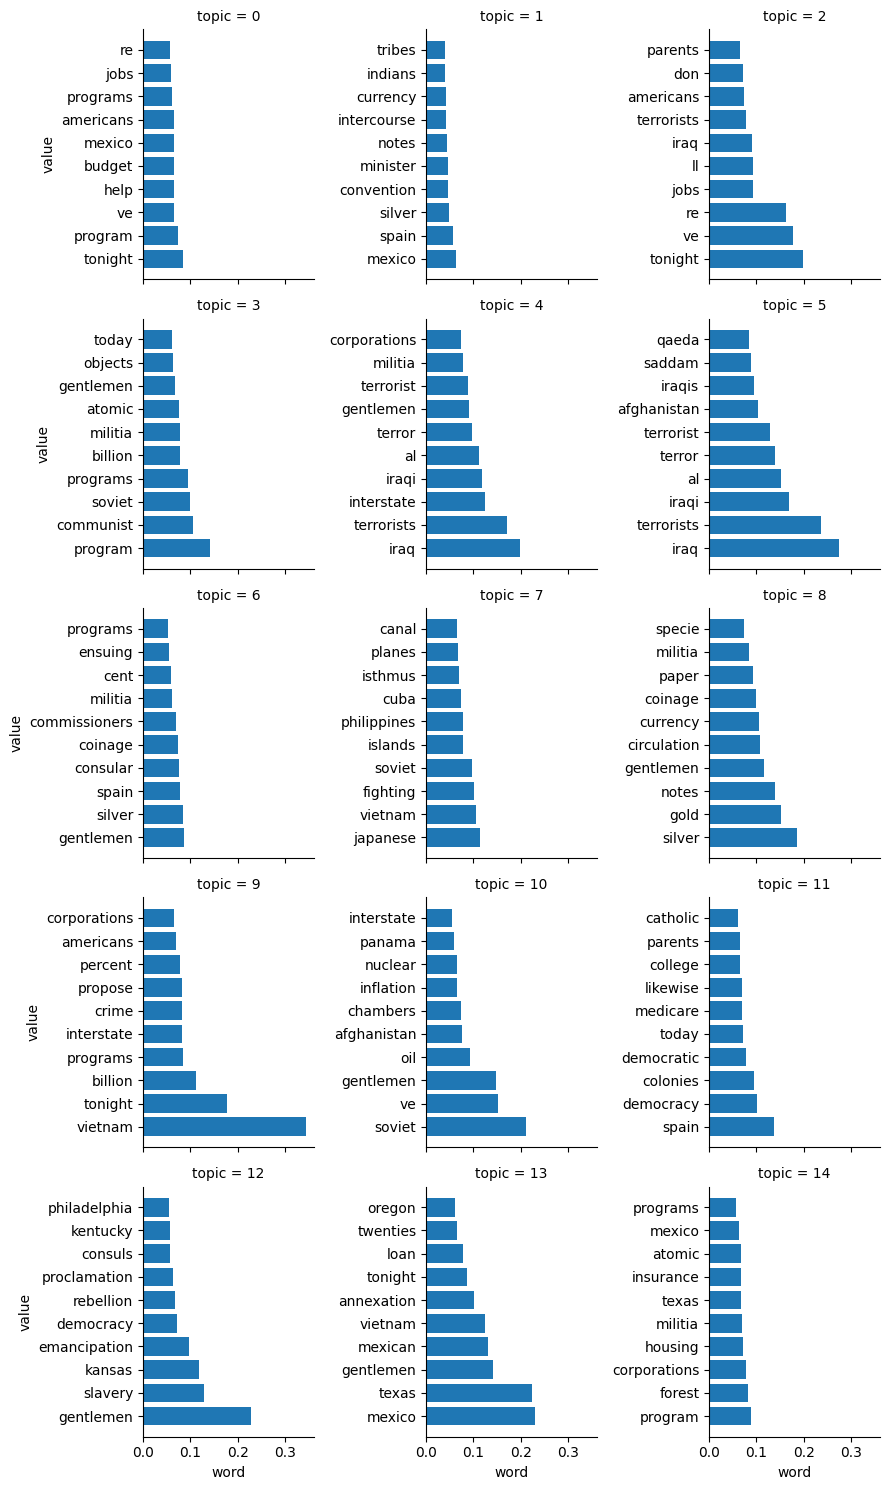

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

## Using LDA with Gensim

Now we'll use LDA.

In [ ]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [ ]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
from gensim import models

n_topics = 15

lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics)

In [ ]:
lda_model.print_topics()

[(0,
  '0.005*"1986" + 0.004*"1260" + 0.004*"1559" + 0.002*"1930" + 0.002*"1242" + 0.002*"1999" + 0.002*"1995" + 0.002*"1865" + 0.002*"1922" + 0.002*"1896"'),
 (1,
  '0.003*"1930" + 0.003*"1986" + 0.003*"1964" + 0.003*"1989" + 0.003*"1260" + 0.002*"1999" + 0.002*"1784" + 0.002*"1626" + 0.002*"1802" + 0.002*"588"'),
 (2,
  '0.004*"1930" + 0.003*"1559" + 0.003*"1260" + 0.003*"1242" + 0.003*"1971" + 0.003*"1986" + 0.003*"1974" + 0.002*"1995" + 0.002*"951" + 0.002*"1964"'),
 (3,
  '0.005*"1559" + 0.003*"1260" + 0.003*"1986" + 0.002*"1446" + 0.002*"1930" + 0.002*"1974" + 0.002*"151" + 0.002*"1626" + 0.002*"1989" + 0.002*"1327"'),
 (4,
  '0.004*"1930" + 0.003*"1986" + 0.003*"1242" + 0.003*"1260" + 0.003*"1974" + 0.003*"1971" + 0.003*"1559" + 0.002*"1989" + 0.002*"578" + 0.002*"1988"'),
 (5,
  '0.004*"1559" + 0.003*"1626" + 0.003*"1986" + 0.003*"1260" + 0.002*"151" + 0.002*"1327" + 0.002*"1865" + 0.002*"1017" + 0.002*"1922" + 0.002*"468"'),
 (6,
  '0.003*"1559" + 0.003*"1986" + 0.003*"1930" +

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 34.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BrokenProcessPool: ignored